In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import model
from data_utils.loader import Loader
from model.deconfounder import Deconfounder
from pyro.optim import Adam
import torch

In [3]:
data_path = "data/ohe_movies.csv"
loader = Loader(data_path)

In [4]:
X_train, X_test, y_train, y_test = loader.get_train_test()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([2544, 129]) torch.Size([637, 129]) torch.Size([2544]) torch.Size([637])


In [33]:

step1_opt = Adam({"lr": 0.005})
step2_opt = Adam({"lr": 0.005})
latent_dim = 50
deconfounder = Deconfounder(step1_opt, step2_opt, 
                            seed=5323, latent_dim=latent_dim,
                            step1_iters=4000, step2_iters=1500)

X_total = torch.cat([X_train, X_test], dim=0)
num_datapoints, data_dim = X_total.shape

print(X_total.shape)
params0 = {
            'z_mean0': torch.zeros([num_datapoints, latent_dim]),
            'z_std0' : torch.ones([num_datapoints, latent_dim]),
            'w_mean0' : torch.zeros([latent_dim, data_dim]),
            'w_std0' : torch.ones([latent_dim, data_dim]),
            'weight_mean0': torch.zeros(data_dim + latent_dim),
            'weight_std0': torch.ones(data_dim + latent_dim),
            'bias_mean0': torch.tensor(0.),
            'bias_std0': torch.tensor(1.),
            'sigma_mean0' : torch.tensor(1.),
            'sigma_std0' : torch.tensor(0.05)
} # These are our priors

torch.Size([3181, 129])


In [104]:
X_total = torch.cat([X_train, X_test], dim=0)


In [34]:
# Here we optimizing only step 1 of deconfounder

step1_params = deconfounder.step1_train(X_total, params0)
step1_params


 Training Z marginal and W parameter marginal...
[iteration 0001] loss: 378.0973
[iteration 0101] loss: 221.7376
[iteration 0201] loss: 25.6455
[iteration 0301] loss: 19.3573
[iteration 0401] loss: 17.8938
[iteration 0501] loss: 17.1269
[iteration 0601] loss: 16.7178
[iteration 0701] loss: 16.2432
[iteration 0801] loss: 15.6417
[iteration 0901] loss: 15.1421
[iteration 1001] loss: 15.1114
[iteration 1101] loss: 14.7474
[iteration 1201] loss: 14.4032
[iteration 1301] loss: 14.0601
[iteration 1401] loss: 13.8766
[iteration 1501] loss: 13.8449
[iteration 1601] loss: 13.3450
[iteration 1701] loss: 13.0726
[iteration 1801] loss: 13.0749
[iteration 1901] loss: 12.6028
[iteration 2001] loss: 12.3165
[iteration 2101] loss: 11.8551
[iteration 2201] loss: 11.5970
[iteration 2301] loss: 11.3658
[iteration 2401] loss: 10.4831
[iteration 2501] loss: 9.6475
[iteration 2601] loss: 9.0498
[iteration 2701] loss: 8.3036
[iteration 2801] loss: 7.6619
[iteration 2901] loss: 7.0294
[iteration 3001] loss: 

{'z_mean0': tensor([[-0.1717,  0.7885, -2.5225,  ...,  0.3397, -2.4244, -0.3137],
         [ 3.5207,  2.4311, -1.4143,  ..., -0.3313, -0.5391,  2.3412],
         [ 3.4924,  1.1116, -0.8684,  ..., -0.9599,  0.2406,  1.0242],
         ...,
         [ 1.3831,  1.1089,  1.4643,  ...,  0.4979, -1.1654, -0.6883],
         [ 0.6036,  1.5237,  0.1871,  ..., -0.5243, -0.9988,  2.2739],
         [ 0.6150,  1.4004,  0.4072,  ..., -0.8382, -1.1138,  0.6044]],
        requires_grad=True),
 'z_std0': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]),
 'w_mean0': tensor([[-0.4153, -1.0522, -0.1768,  ..., -0.2091, -0.7713,  0.3972],
         [-0.8241, -0.5299, -0.9714,  ..., -0.8765, -1.0732, -0.7600],
         [ 1.3297,  0.0956,  0.8961,  ...,  0.0656, -0.0156, -1.4201],
         ...,
         

In [15]:
Z_train = step1_params['qz_mean'][:X_train.shape[0], :]
Z_test = step1_params['qz_mean'][X_train.shape[0]:, :]
Z_train.shape, Z_test.shape

(torch.Size([2544, 50]), torch.Size([637, 50]))

In [16]:
reg_train = torch.cat([X_train, Z_train], dim=1)
reg_test = torch.cat([X_test, Z_test], dim=1)
reg_train.shape, reg_test.shape

(torch.Size([2544, 179]), torch.Size([637, 179]))

In [21]:
actors = loader.data_X.columns[:-1]
actors

Index(['Adam Sandler', 'Alec Baldwin', 'Amy Adams', 'Angelina Jolie',
       'Anna Faris', 'Anne Hathaway', 'Anthony Hopkins', 'Anthony Mackie',
       'Antonio Banderas', 'Arnold Schwarzenegger',
       ...
       'Sylvester Stallone', 'Tom Cruise', 'Tom Hanks', 'Tom Wilkinson',
       'Tommy Lee Jones', 'Vince Vaughn', 'Will Ferrell', 'Will Smith',
       'Willem Dafoe', 'Woody Harrelson'],
      dtype='object', length=129)

# Vanilla linear regression and deconfounded one

In [23]:
# ElasticNet with deconfounder using random train-test split
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV

lr_dec = ElasticNetCV(eps=1e-2, l1_ratio=0.001, alphas=np.arange(0.001, 0.1, 0.001))
lr_dec.fit(reg_train.numpy(), y_train.numpy())
y_pred = lr_dec.predict(reg_test.numpy())
mse = mean_squared_error(y_test.numpy(), y_pred)

y_mean = np.zeros(y_test.shape) + y_train.numpy().mean()
mean_mse = mean_squared_error(y_test.numpy(), y_mean)
print(f'Linear regression MSE: {mse:.4f}, mean baseline mse: {mean_mse:.4f}')

reg_actors = pd.DataFrame(data=lr_dec.coef_[:-latent_dim],
                          columns=['weight'], index=actors)
reg_actors.sort_values(by='weight', ascending=False).head(10)

Linear regression MSE: 1.8229, mean baseline mse: 1.9978


,weight
Robin Williams,0.296117
Mark Wahlberg,0.283870
Tom Hanks,0.278979
Tom Cruise,0.259164
Ralph Fiennes,0.251289
Matt Damon,0.236043
Samuel L. Jackson,0.227429
Don Cheadle,0.202236
Ben Stiller,0.187346
Eddie Murphy,0.185152


In [25]:
lr = ElasticNetCV(eps=1e-2, l1_ratio=0.001, alphas=np.arange(0.001, 0.1, 0.001))
lr.fit(X_train.numpy(), y_train.numpy())
y_pred = lr.predict(X_test.numpy())
mse = mean_squared_error(y_test.numpy(), y_pred)

y_mean = np.zeros(y_test.shape) + y_train.numpy().mean()
mean_mse = mean_squared_error(y_test.numpy(), y_mean)
print(f'Linear regression MSE: {mse:.4f}, mean baseline mse: {mean_mse:.4f}')

simple_actors = pd.DataFrame(data=lr.coef_,
                          columns=['weight'], index=actors)
reg_actors.loc[:, 'uncorrected_weight'] = simple_actors.weight
simple_actors.sort_values(by='weight', ascending=False).head(10)

Linear regression MSE: 1.8272, mean baseline mse: 1.9978


,weight
Will Smith,1.001627
Tom Cruise,0.880175
Robin Williams,0.836293
Tom Hanks,0.799102
Ralph Fiennes,0.724788
Adam Sandler,0.713808
Arnold Schwarzenegger,0.690666
Samuel L. Jackson,0.689969
Morgan Freeman,0.679819
Eddie Murphy,0.661010


# Region top actors comp

In [27]:
# here we calculating total actor influence on revenue
actors_count = X_total.sum(dim=0).numpy()
reg_actors.loc[:, 'actors_count'] = actors_count
reg_actors.loc[:, 'total_influence'] = actors_count * reg_actors.weight
reg_actors.loc[:, 'uncorrected_total_influence'] = actors_count * reg_actors.uncorrected_weight

print('Sorted by actor influence on log revenue using deconfounder')
reg_actors.sort_values(by='total_influence', ascending=False).head(25)



Sorted by actor influence on log revenue using deconfounder


,weight,uncorrected_weight,actors_count,total_influence,uncorrected_total_influence
Samuel L. Jackson,0.227429,0.689969,44.0,10.006854,30.358646
Matt Damon,0.236043,0.586008,37.0,8.733575,21.682301
Morgan Freeman,0.184854,0.679819,45.0,8.318420,30.591854
Mark Wahlberg,0.283870,0.518768,29.0,8.232220,15.044276
Tom Hanks,0.278979,0.799102,29.0,8.090385,23.173967
Tom Cruise,0.259164,0.880175,30.0,7.774920,26.405262
Robin Williams,0.296117,0.836293,25.0,7.402925,20.907330
Johnny Depp,0.166416,0.590750,35.0,5.824553,20.676250
Ben Stiller,0.187346,0.372272,31.0,5.807725,11.540442
Ralph Fiennes,0.251289,0.724788,21.0,5.277061,15.220543


In [29]:
print('Sorted by actor influence on log revenue using only actors as variables')
reg_actors.sort_values(by='uncorrected_total_influence', ascending=False).head(25)

Sorted by actor influence on log revenue using only actors as variables


,weight,uncorrected_weight,actors_count,total_influence,uncorrected_total_influence
Morgan Freeman,0.184854,0.679819,45.0,8.318420,30.591854
Samuel L. Jackson,0.227429,0.689969,44.0,10.006854,30.358646
Tom Cruise,0.259164,0.880175,30.0,7.774920,26.405262
Tom Hanks,0.278979,0.799102,29.0,8.090385,23.173967
Will Smith,0.133549,1.001627,23.0,3.071619,23.037432
Matt Damon,0.236043,0.586008,37.0,8.733575,21.682301
Robin Williams,0.296117,0.836293,25.0,7.402925,20.907330
Johnny Depp,0.166416,0.590750,35.0,5.824553,20.676250
Arnold Schwarzenegger,0.155276,0.690666,26.0,4.037177,17.957325
Adam Sandler,0.171077,0.713808,25.0,4.276924,17.845211


In [31]:
print('Actors sorted by change of inlfuence caused by deconfounding')
reg_actors.loc[:, 'influence_diff'] = reg_actors.total_influence - reg_actors.uncorrected_total_influence
reg_actors.sort_values(by='influence_diff', ascending=False).head(25)

Actors sorted by change of inlfuence caused by deconfounding


,weight,uncorrected_weight,actors_count,total_influence,uncorrected_total_influence,influence_diff
Christopher Walken,-0.094075,-0.308028,23.0,-2.163715,-7.084640,4.920925
Vince Vaughn,0.070756,-0.130451,22.0,1.556625,-2.869930,4.426555
Susan Sarandon,-0.153100,-0.321713,23.0,-3.521306,-7.399405,3.878099
Colin Farrell,-0.187256,-0.368532,21.0,-3.932384,-7.739182,3.806798
Ben Kingsley,-0.048640,-0.151313,28.0,-1.361910,-4.236751,2.874840
Christian Bale,-0.016274,-0.090520,25.0,-0.406855,-2.262996,1.856142
Kate Winslet,0.061652,0.003114,22.0,1.356349,0.068515,1.287834
Ewan McGregor,-0.220590,-0.255545,26.0,-5.735341,-6.644176,0.908836
Kirsten Dunst,0.078027,0.049737,20.0,1.560547,0.994746,0.565802
Julianne Moore,-0.061737,-0.079258,23.0,-1.419958,-1.822928,0.402970


Susan Sarandon and Christopher Walken were replicated from Blei et al "most improved actors"

In [32]:
print('Actors sorted by change of per-movie inlfuence caused by deconfounding')
reg_actors.loc[:, 'weight_diff'] = reg_actors.weight - reg_actors.uncorrected_weight
reg_actors.sort_values(by='weight_diff', ascending=False).head(25).

Actors sorted by change of per-movie inlfuence caused by deconfounding


,weight,uncorrected_weight,actors_count,total_influence,uncorrected_total_influence,influence_diff,weight_diff
Christopher Walken,-0.094075,-0.308028,23.0,-2.163715,-7.084640,4.920925,0.213953
Vince Vaughn,0.070756,-0.130451,22.0,1.556625,-2.869930,4.426555,0.201207
Colin Farrell,-0.187256,-0.368532,21.0,-3.932384,-7.739182,3.806798,0.181276
Susan Sarandon,-0.153100,-0.321713,23.0,-3.521306,-7.399405,3.878099,0.168613
Ben Kingsley,-0.048640,-0.151313,28.0,-1.361910,-4.236751,2.874840,0.102673
Christian Bale,-0.016274,-0.090520,25.0,-0.406855,-2.262996,1.856142,0.074246
Kate Winslet,0.061652,0.003114,22.0,1.356349,0.068515,1.287834,0.058538
Ewan McGregor,-0.220590,-0.255545,26.0,-5.735341,-6.644176,0.908836,0.034955
Kirsten Dunst,0.078027,0.049737,20.0,1.560547,0.994746,0.565802,0.028290
Julianne Moore,-0.061737,-0.079258,23.0,-1.419958,-1.822928,0.402970,0.017520


# Movies comparison

In [415]:
y_test_dec = lr_dec.predict(reg_test.numpy())
y_test_lr = lr.predict(X_test.numpy())

movies = loader.data_test.loc[:, ['title_x']]
movies.loc[:, 'log_revenue'] = y_test.numpy()
movies.loc[:, 'dec_revenue'] = y_test_dec
movies.loc[:, 'uncorrected_revenue'] = y_test_lr
movies.loc[:, 'revenue_diff'] = y_test_dec - y_test_lr
movies.sort_values(by='revenue_diff', ascending=False).head(25)

,title_x,log_revenue,dec_revenue,uncorrected_revenue,revenue_diff
1092,The Ghost Writer,17.913553,18.767284,18.041582,0.725702
928,Moneyball,18.517864,18.730017,18.056925,0.673092
502,The Invasion,16.528316,18.260983,17.620211,0.640772
1416,Jersey Girl,17.401758,19.307318,18.720648,0.586670
112,Alexander,18.935287,18.484087,17.911892,0.572195
233,Star Wars: Episode I - The Phantom Menace,20.644566,17.966166,17.423592,0.542574
54,The Good Dinosaur,19.620422,17.961765,17.429478,0.532288
1780,Shakespeare in Love,19.483036,18.243023,17.716375,0.526648
534,Bandits,18.029591,18.910530,18.391968,0.518562
149,Armageddon,20.132313,18.936989,18.453531,0.483458


In [405]:
movies.sort_values(by='revenue_diff', ascending=True).head(25)

,title_x,log_revenue,dec_revenue,uncorrected_revenue,revenue_diff
2930,The Secret Life of Bees,17.455866,17.248714,17.742914,-0.494200
249,Insurgent,19.503294,17.008175,17.459867,-0.451693
1966,Old School,18.282055,17.038462,17.480112,-0.441650
2397,Hotel Rwanda,17.453096,17.459105,17.897995,-0.438890
2701,Little Children,16.511600,17.024311,17.459867,-0.435556
4268,"Lock, Stock and Two Smoking Barrels",15.175864,17.321125,17.716877,-0.395752
121,Night at the Museum: Battle of the Smithsonian,19.839214,18.933870,19.306471,-0.372601
3631,Heavenly Creatures,14.930368,17.111633,17.459867,-0.348234
1340,We're the Millers,19.413910,17.226593,17.570444,-0.343851
1352,Gattaca,16.343859,17.295771,17.631926,-0.336155


In [406]:
movies.sort_values(by='uncorrected_revenue', ascending=False).head(25)

,title_x,log_revenue,dec_revenue,uncorrected_revenue,revenue_diff
307,The Expendables 3,19.144224,19.385006,19.551682,-0.166676
1688,Confessions of a Dangerous Mind,17.312437,19.440599,19.520990,-0.080391
7,Avengers: Age of Ultron,21.063591,19.108477,19.421356,-0.312880
121,Night at the Museum: Battle of the Smithsonian,19.839214,18.933870,19.306471,-0.372601
912,Interview with the Vampire,19.225658,19.238619,19.160915,0.077703
3232,Pulp Fiction,19.181154,19.301064,19.062634,0.238430
105,Alice Through the Looking Glass,19.517191,19.016823,19.030354,-0.013531
185,War of the Worlds,20.198576,18.879635,19.016747,-0.137112
524,Charlie Wilson's War,18.594637,18.959188,19.003426,-0.044237
316,Gangs of New York,19.082195,19.427183,18.987789,0.439394


In [407]:
y_train_dec = lr_dec.predict(reg_train.numpy())
y_train_lr = lr.predict(X_train.numpy())

movies = loader.data_train.loc[:, ['title_x']]
movies.loc[:, 'log_revenue'] = y_train.numpy()
movies.loc[:, 'dec_revenue'] = y_train_dec
movies.loc[:, 'uncorrected_revenue'] = y_train_lr
movies.loc[:, 'revenue_diff'] = y_train_dec - y_train_lr
movies.sort_values(by='revenue_diff', ascending=False).head(25)

,title_x,log_revenue,dec_revenue,uncorrected_revenue,revenue_diff
1774,What Just Happened,15.713643,19.238396,18.377396,0.861000
1972,The Men Who Stare at Goats,18.045687,18.819624,17.959322,0.860302
2008,In the Valley of Elah,17.201317,18.538967,17.690865,0.848103
1424,Concussion,17.734783,19.703407,18.859320,0.844088
2231,Strange Wilderness,15.698828,18.602039,17.813490,0.788549
462,The Manchurian Candidate,18.380962,18.855844,18.127605,0.728239
3348,Capote,17.709061,18.015059,17.402073,0.612986
273,Gone in Sixty Seconds,19.284424,18.760847,18.163874,0.596973
590,The Siege,18.574884,18.852146,18.274990,0.577156
1726,Rob Roy,17.268570,18.386082,17.810324,0.575758


In [408]:
movies.sort_values(by='revenue_diff', ascending=True).head(25)

,title_x,log_revenue,dec_revenue,uncorrected_revenue,revenue_diff
2034,Delivery Man,17.750549,16.686201,17.326302,-0.640100
3773,Thumbsucker,14.467418,16.704742,17.326302,-0.621559
3623,Made,15.515897,16.753267,17.326302,-0.573034
1689,Serving Sara,16.644609,17.170109,17.714130,-0.544022
1081,Revolutionary Road,18.136003,16.966721,17.459867,-0.493147
2299,Leap Year,17.214121,17.225267,17.714130,-0.488863
4671,Swingers,15.320904,16.853222,17.326302,-0.473080
25,Titanic,21.335764,16.989866,17.459867,-0.470001
2554,The Wedding Date,17.669376,17.245171,17.714130,-0.468960
1158,Lone Survivor,18.821440,17.508568,17.975521,-0.466953


0.10927912784387153


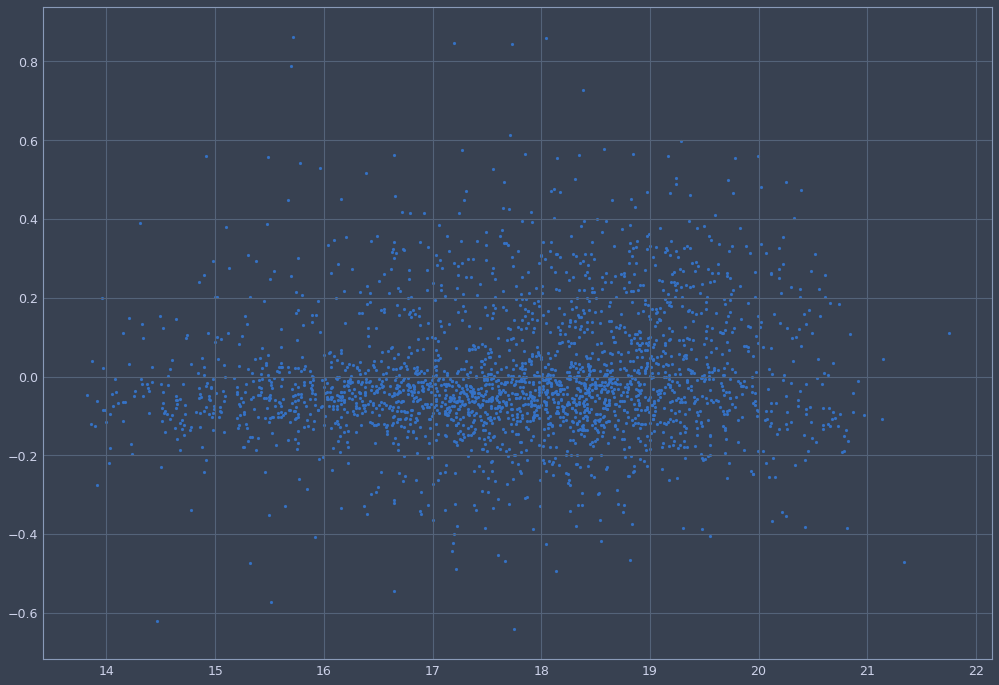

In [409]:
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style()


corr = np.corrcoef(movies.log_revenue, movies.revenue_diff, rowvar=False)
print(corr[0, 1])
plt.figure(figsize=(17, 12))
plt.scatter(movies.log_revenue, movies.revenue_diff, s=9)
plt.show()

In [389]:
movies.diff

<bound method DataFrame.diff of                    title_x  log_revenue  dec_revenue  uncorrected_revenue  \
1057          Coach Carter    18.155018    18.738129            18.634760   
2454       Dumb and Dumber    19.326014    17.920782            17.934654   
3040           The Matador    16.666058    18.280598            18.056334   
1890      Don Juan DeMarco    16.915604    17.865227            18.047503   
3860          High Anxiety    17.251530    17.280315            17.456753   
...                    ...          ...          ...                  ...   
346      What Lies Beneath    18.861927    17.581089            17.824591   
1220                   8MM    18.386282    17.691029            17.583067   
43    Terminator Salvation    19.732664    17.744726            17.804193   
2145           Wild Things    18.023184    17.474640            17.420227   
1661             Antitrust    16.716690    17.252954            17.456753   

          diff  
1057  0.103369  
2454 -0.0

# Region movie analysis

In [417]:
movies_info = pd.read_csv('data/tmdb_5000_movies.csv', index_col='id')
movies_info

,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
id,,,,,,,,,,,,,,,,,,,
19995,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
285,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
206647,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
49026,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
49529,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
72766,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
231617,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958

In [419]:
movies_info.loc[9367, :]

budget                                                             220000
genres                  [{"id": 28, "name": "Action"}, {"id": 80, "nam...
homepage                                                              NaN
keywords                [{"id": 5616, "name": "united states\u2013mexi...
original_language                                                      es
original_title                                                El Mariachi
overview                El Mariachi just wants to play his guitar and ...
popularity                                                        14.2698
production_companies             [{"name": "Columbia Pictures", "id": 5}]
production_countries    [{"iso_3166_1": "MX", "name": "Mexico"}, {"iso...
release_date                                                   1992-09-04
revenue                                                           2040920
runtime                                                                81
spoken_languages            [{"iso_639

In [424]:
loader.data_train[loader.data_train.title_x == 'El Mariachi']

,Adam Sandler,Alec Baldwin,Amy Adams,Angelina Jolie,Anna Faris,Anne Hathaway,Anthony Hopkins,Anthony Mackie,Antonio Banderas,Arnold Schwarzenegger,...,Tom Cruise,Tom Hanks,Tom Wilkinson,Tommy Lee Jones,Vince Vaughn,Will Ferrell,Will Smith,Willem Dafoe,Woody Harrelson,title_x
4798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,El Mariachi


In [427]:
non_en = movies_info[movies_info.original_language != 'en']
non_en

,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
id,,,,,,,,,,,,,,,,,,,
315011,15000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,"[{""id"": 1299, ""name"": ""monster""}, {""id"": 7671,...",ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,9.476999,"[{""name"": ""Cine Bazar"", ""id"": 5896}, {""name"": ...","[{""iso_3166_1"": ""JP"", ""name"": ""Japan""}]",2016-07-29,77000000,120.0,"[{""iso_639_1"": ""it"", ""name"": ""Italiano""}, {""is...",Released,A god incarnate. A city doomed.,Shin Godzilla,6.5,143
2395,97250400,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 12, ""na...",http://www.asterixauxjeuxolympiques.com/index.php,"[{""id"": 271, ""name"": ""competition""}, {""id"": 12...",fr,Astérix aux Jeux Olympiques,Astérix and Obélix have to win the Olympic Gam...,20.344364,"[{""name"": ""Constantin Film"", ""id"": 47}, {""name...","[{""iso_3166_1"": ""BE"", ""name"": ""Belgium""}, {""is...",2008-01-13,132900000,116.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,NaN,Asterix at the Olympic Games,5.0,471
76758,94000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 36, ""name...",http://www.theflowersofwarmovie.com/,"[{""id"": 173251, ""name"": ""forced prostitution""}...",zh,金陵十三釵,A Westerner finds refuge with a group of women...,12.516546,"[{""name"": ""Beijing New Picture Film Co. Ltd."",...","[{""iso_3166_1"": ""CN"", ""name"": ""China""}, {""iso_...",2011-12-15,95311434,145.0,"[{""iso_639_1"": ""zh"", ""name"": ""\u666e\u901a\u8b...",Released,NaN,The Flowers of War,7.1,187
330770,0,"[{""id"": 9648, ""name"": ""Mystery""}, {""id"": 18, ""...",NaN,"[{""id"": 428, ""name"": ""nurse""}, {""id"": 658, ""na...",fr,Évolution,11-year-old Nicolas lives with his mother in a...,3.300061,"[{""name"": ""Ex Nihilo"", ""id"": 3307}, {""name"": ""...","[{""iso_3166_1"": ""BE"", ""name"": ""Belgium""}, {""is...",2015-09-14,0,81.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""}]",Released,NaN,Evolution,6.4,47
293644,8000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 16, ""nam...",NaN,"[{""id"": 209714, ""name"": ""3d""}]",es,Don Gato: El inicio de la pandilla,Top Cat has arrived to charm his way into your...,0.719996,"[{""name"": ""Anima Estudios"", ""id"": 9965}, {""nam...","[{""iso_3166_1"": ""IN"", ""name"": ""India""}, {""iso_...",2015-10-30,0,89.0,[],Released,NaN,Top Cat Begins,5.3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90414,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,"[{""id"": 187056, ""name"": ""woman director""}]",fr,"I Love You, Don't Touch Me!","The story of a 25 year old virgin girl, lookin...",0.020839,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-01-21,0,86.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Just Your Typical Boy-Loves-Girl Who Doesn't L...,"I Love You, Don't Touch Me!",6.0,1
42109,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",NaN,[],pt,"Gabriela, Cravo e Canela","In 1925, Gabriela becomes cook, mistress, and ...",0.557602,"[{""name"": ""United Artists"", ""id"": 60}, {""name""...","[{""iso_3166_1"": ""BR"", ""name"": ""Brazil""}]",1983-03-24,0,99.0,"[{""iso_639_1"": ""pt"", ""name"": ""Portugu\u00eas""}]",Released,NaN,Gabriela,6.0,2
13898,0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10769, ""n...",NaN,[],fa,دایره,Various women struggle to function in the oppr...,1.193779,"[{""name"": ""Jafar Panahi Film Productions"", ""id...","[{""iso_3166_1"": ""IR"", ""name"": ""Iran""}]",2000-09-08,0,90.0,"[{""iso_639_1"": ""fa"", ""name"": ""\u0641\u0627\u06...",Released,NaN,The Circle,6.6,17


In [432]:
loader.data_test

,Adam Sandler,Alec Baldwin,Amy Adams,Angelina Jolie,Anna Faris,Anne Hathaway,Anthony Hopkins,Anthony Mackie,Antonio Banderas,Arnold Schwarzenegger,...,Tom Cruise,Tom Hanks,Tom Wilkinson,Tommy Lee Jones,Vince Vaughn,Will Ferrell,Will Smith,Willem Dafoe,Woody Harrelson,title_x
1057,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Coach Carter
2454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dumb and Dumber
3040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,The Matador
1890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Don Juan DeMarco
3860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,High Anxiety
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,What Lies Beneath
1220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8MM
43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Terminator Salvation
2145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Wild Things


In [431]:
loader.data_test.merge(non_en, how='inner', left_on='title_x', right_on='title')


,Adam Sandler,Alec Baldwin,Amy Adams,Angelina Jolie,Anna Faris,Anne Hathaway,Anthony Hopkins,Anthony Mackie,Antonio Banderas,Arnold Schwarzenegger,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,0,0,0,0,0,0,0,0,0,0,...,"[{""iso_3166_1"": ""RU"", ""name"": ""Russia""}]",2013-07-26,4037782,120.0,"[{""iso_639_1"": ""ru"", ""name"": ""P\u0443\u0441\u0...",Released,NaN,The Geographer Drank His Globe Away,7.3,23
1,0,0,0,0,0,0,0,0,0,0,...,"[{""iso_3166_1"": ""JP"", ""name"": ""Japan""}]",1999-12-11,10037390,107.0,"[{""iso_639_1"": ""ja"", ""name"": ""\u65e5\u672c\u8a...",Released,Get ready to crumble.,Godzilla 2000,5.9,43
2,0,0,0,0,0,0,0,0,0,0,...,"[{""iso_3166_1"": ""BE"", ""name"": ""Belgium""}, {""is...",2005-11-09,17709155,116.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,France 1914. A moment of humanity that made hi...,Joyeux Noël,7.2,212
3,0,0,0,0,0,0,0,0,0,0,...,[],2011-01-01,2570000,89.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,From zero to hero.,Legend of a Rabbit,3.0,3
4,0,0,0,0,0,0,0,0,0,0,...,"[{""iso_3166_1"": ""ZA"", ""name"": ""South Africa""}]",2005-08-18,9879971,94.0,"[{""iso_639_1"": ""af"", ""name"": ""Afrikaans""}, {""i...",Released,In this world... Redemption comes just once.,Tsotsi,6.9,94
5,0,0,0,0,0,0,0,0,0,0,...,"[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2013-05-21,8371085,142.0,"[{""iso_639_1"": ""it"", ""name"": ""Italiano""}, {""is...",Released,NaN,The Great Beauty,7.3,720
6,0,0,0,0,0,0,0,0,0,0,...,"[{""iso_3166_1"": ""ID"", ""name"": ""Indonesia""}, {""...",2011-09-08,4105187,101.0,"[{""iso_639_1"": ""id"", ""name"": ""Bahasa indonesia""}]",Released,"1 Ruthless Crime Lord, 20 Elite Cops, 30 Floor...",The Raid,7.3,1055
7,0,0,0,0,0,0,0,0,0,0,...,"[{""iso_3166_1"": ""FR"", ""name"": ""France""}]",2005-01-26,127392239,80.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,"In the harshest place on Earth, love finds a way.",March of the Penguins,6.9,358
8,0,0,0,0,0,0,0,0,0,0,...,"[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}]",1998-08-20,7267585,81.0,"[{""iso_639_1"": ""de"", ""name"": ""Deutsch""}, {""iso...",Released,Every second of every day you're faced with a ...,Run Lola Run,7.2,664
9,0,0,0,0,0,0,0,0,0,0,...,"[{""iso_3166_1"": ""RU"", ""name"": ""Russia""}]",2012-10-11,12400000,76.0,"[{""iso_639_1"": ""ru"", ""name"": ""P\u0443\u0441\u0...",Released,"Cold can freeze your heart, love can set you free",The Snow Queen,5.1,47


In [429]:
non_en.columns

Index(['budget', 'genres', 'homepage', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

# Region counterfactuals

In [35]:
y_total = torch.cat([y_train, y_test], dim=0)

step2_params = deconfounder.step2_train(X_total, 
                                        y_total, 
                                        step1_params, 
                                        num_samples=2000)

Training Bayesian regression parameters...
[iteration 0001] loss: 209.5584


/home/ag3r/anaconda3/envs/causality/lib/python3.7/site-packages/pyro/infer/svi.py:53: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  'samples from the posterior.', FutureWarning)


[iteration 0101] loss: 30.3625
[iteration 0201] loss: 24.2038
[iteration 0301] loss: 19.3358
[iteration 0401] loss: 14.9422
[iteration 0501] loss: 11.7506
[iteration 0601] loss: 10.1998
[iteration 0701] loss: 10.5387
[iteration 0801] loss: 9.8479
[iteration 0901] loss: 8.8503
[iteration 1001] loss: 8.6369
[iteration 1101] loss: 6.5288
[iteration 1201] loss: 6.1761
[iteration 1301] loss: 5.7313


/home/ag3r/anaconda3/envs/causality/lib/python3.7/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


[iteration 1401] loss: nan
Updating value of hypermeter: w_loc
Updating value of hypermeter: w_scale
Updating value of hypermeter: b_loc
Updating value of hypermeter: b_scale
Updating value of hypermeter: sigma_loc
Updating value of hypermeter: sigma_scale
Training complete.


In [43]:

data_total = pd.concat([loader.data_train, loader.data_test], axis=0, ignore_index=True)
data_total[data_total.title_x.str.contains('Batman')]

,Adam Sandler,Alec Baldwin,Amy Adams,Angelina Jolie,Anna Faris,Anne Hathaway,Anthony Hopkins,Anthony Mackie,Antonio Banderas,Arnold Schwarzenegger,...,Tom Cruise,Tom Hanks,Tom Wilkinson,Tommy Lee Jones,Vince Vaughn,Will Ferrell,Will Smith,Willem Dafoe,Woody Harrelson,title_x
1554,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Batman Begins
1720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Batman Forever
2326,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Batman & Robin
2566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Batman
2607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Batman Returns
3001,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Batman v Superman: Dawn of Justice


## Conterfactual #1

Who is the best batman instead of Affleck's chin in Dawn of Justice?

In [100]:
# we will check top 5 most underrated male actors of appropriate age

actors_to_check = ['Vince Vaughn', 'Colin Farrell', 'Christian Bale', 
                   'Woody Harrelson', 'Steve Zahn']

deconfounder.step2_params = step2_params
movie_mask = (data_total.title_x == 'Batman v Superman: Dawn of Justice')
affleck_mask = (reg_actors.index == 'Ben Affleck') # haha 
for actor in actors_to_check:
    actor_mask = (reg_actors.index == actor)
    intervention = X_total.clone().detach()
    intervention[movie_mask, actor_mask] = 1
    intervention[movie_mask, affleck_mask] = 0
    
    causal_effect = deconfounder.do_causal(intervention, X_total, movie_mask, num_samples=2000)
    print(f'actor {actor} has {causal_effect:.3f} influence on Dawn of Justice')
    

actor Vince Vaughn has 0.357 influence on Dawn of Justice
actor Colin Farrell has 0.195 influence on Dawn of Justice
actor Christian Bale has 0.067 influence on Dawn of Justice
actor Woody Harrelson has 0.166 influence on Dawn of Justice
actor Steve Zahn has -0.321 influence on Dawn of Justice


## Counterfactual #2

Replace Top5 most expensive movie roles all time with underrated actors

In [101]:
# source is https://www.businessinsider.com/16-of-the-highest-paid-movie-roles-of-all-time-2018-5

top5_roles = {
    'Will Smith': 'Men in Black 3', # 100 million
    'Johnny Depp': 'Alice ', # space is for filtering out 'Still Alice'
    'Tom Cruise': 'Mission: Impossible',
    'Robert Downey Jr.': 'Avengers',
    'Sandra Bullock': 'Gravity'
}

actors_to_replace = {
    'Will Smith': ['Christopher Walken', 'Dennis Quaid', 'Anthony Mackie'],
    'Johnny Depp': ['Vince Vaughn', 'Colin Farrell', 'Ben Kingsley'],
    'Tom Cruise': ['Steve Zahn', 'Woody Harrelson', 'Jason Statham'],
    'Robert Downey Jr.': ['Luis Guzmán', 'Christian Bale', 'Ewan McGregor'],
    'Sandra Bullock': ['Susan Sarandon', 'Queen Latifah', 'Kate Winslet']
}

In [107]:
#deconfounder.step2_params = step2_params
for old_actor, movie_query in top5_roles.items():
    movie_mask = (data_total.title_x.str.contains(movie_query))
    old_mask = (reg_actors.index == old_actor)
    
    for actor in actors_to_replace[old_actor]:
        intervention = X_total.clone().detach()
        intervention[movie_mask, actor_mask] = 1
        intervention[movie_mask, old_mask] = 0
        causal_effect = deconfounder.do_causal(intervention, 
                                               X_total.clone().detach(), 
                                               movie_mask, 
                                               num_samples=1000)
        
        print(f'actor {actor} has {causal_effect:.3f} influence on {movie_query} over {old_actor}')

actor Christopher Walken has -0.945 influence on Men in Black 3 over Will Smith
actor Dennis Quaid has -0.661 influence on Men in Black 3 over Will Smith
actor Anthony Mackie has -0.651 influence on Men in Black 3 over Will Smith
actor Vince Vaughn has -0.686 influence on Alice  over Johnny Depp
actor Colin Farrell has -1.104 influence on Alice  over Johnny Depp
actor Ben Kingsley has -0.404 influence on Alice  over Johnny Depp
actor Steve Zahn has -1.829 influence on Mission: Impossible over Tom Cruise
actor Woody Harrelson has -1.766 influence on Mission: Impossible over Tom Cruise
actor Jason Statham has -2.425 influence on Mission: Impossible over Tom Cruise
actor Luis Guzmán has -1.039 influence on Avengers over Robert Downey Jr.
actor Christian Bale has -0.964 influence on Avengers over Robert Downey Jr.
actor Ewan McGregor has -1.463 influence on Avengers over Robert Downey Jr.
actor Susan Sarandon has -0.350 influence on Gravity over Sandra Bullock
actor Queen Latifah has -0.54

# Counterfactual #3 - Does Lois Guzman make each movie better?

In [106]:
# we will check all movies against Lois Guzman


deconfounder.step2_params = step2_params
guzman_mask = (reg_actors.index == 'Luis Guzmán') # haha 
movie_mask = ~X_total[:, guzman_mask].squeeze(1).bool().clone().detach()

intervention = X_total.clone().detach()
intervention[movie_mask, guzman_mask] = 1
    
causal_effect = deconfounder.do_causal(intervention, X_total, movie_mask, num_samples=5000)
print(f'Luis Guzmán makes {causal_effect/3161:.3f} influence on movies')
    

Luis Guzmán makes 1.165 influence on movies
